In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import itertools
from scipy.ndimage import median_filter
from matplotlib.colors import Normalize

## Input of PIV results and aggregate images

Load the image that is going to be handeled. Give the file paths for PIV vector fields and aggregate image files to load the data.

In [3]:
# # open .h5 file containing piv results.
# h5_file_path = "F:/PhD_Franziska/Headon/RedBeads/piv_cut1(2)/subregion_all_frame/"
# with h5py.File(h5_file_path, "r") as h5f:
#     U = h5f["U"][:] # shape: frame, rows, columns 
#     V = h5f["V"][:]
#     M = h5f["M"][:]
#     xgrid = h5f["xgrid"][:]
#     ygrid = h5f["ygrid"][:]

In [4]:
# Alternative: Open .h5 file containing piv results. (if files were stored saperatly)
# Load the PIV data. 
h5_file_path = "F:/PhD_Franziska/Headon/RedBeads/GFP_skin/PIV_results_all_frame(frame_dist=5)/"
with h5py.File(h5_file_path+"U_matrix", "r") as h5f:
    U = h5f["matrix"][:] # shape: frame, rows, columns 

with h5py.File(h5_file_path+"V_matrix", "r") as h5f:
    V = h5f["matrix"][:]

with h5py.File(h5_file_path+"M_matrix", "r") as h5f:
    M = h5f["matrix"][:]

with h5py.File(h5_file_path+"xgrid_matrix", "r") as h5f:
    xgrid = h5f["matrix"][:]

with h5py.File(h5_file_path+"ygrid_matrix", "r") as h5f:
    ygrid = h5f["matrix"][:]

In [5]:
# open .h5 file for aggregate images and original red beads images
aggregate_file_path = "F:/PhD_Franziska/Headon/RedBeads/GFP_skin/subregion_Epithelial_mesenchyme_recombinations_scene 2_cropped.h5" 

with h5py.File(aggregate_file_path, "r") as h5f:
    aggregate = h5f["green"][:]
    red_beads = h5f["red"][:]

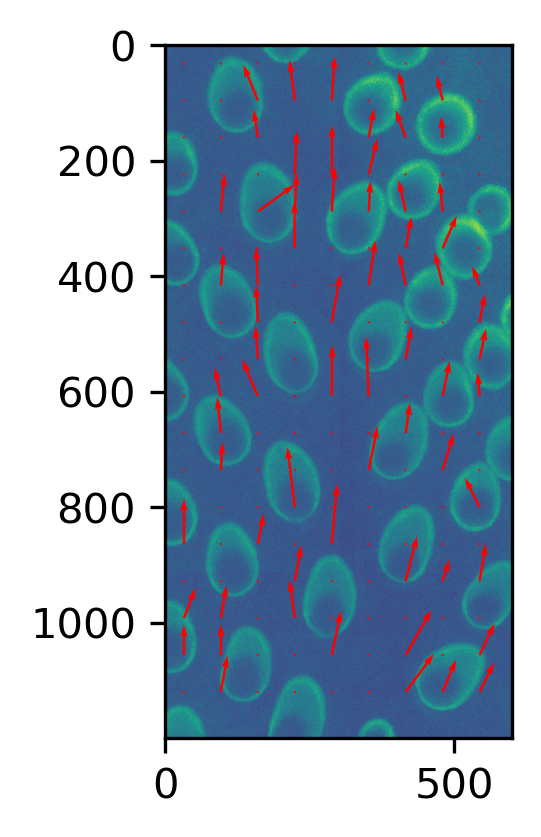

In [18]:
# # Visualise the PIV results for a certain time point. 
# t = 105
# pxl_conversion = 1.8

# plt.figure(figsize=(3, 3), dpi=300)

# plt.imshow(aggregate[300])
# plt.quiver(ygrid[t], xgrid[t], U[t], -V[t], color = "red", width=0.007)
# # # Highlight the reference polarisation vector (manually determined).
# # plt.quiver([280], [950], [3], [28], color="white") # center in x, y coordinate!
# # plt.quiver([480], [1100], [7], [10], color="white")
# # plt.xticks([0, 500], (np.array([0, 500])*pxl_conversion).astype(int))
# # plt.xlabel("distance (μm)")
# # plt.yticks([0, 500, 1000], (np.array([0, 500, 1000])*pxl_conversion).astype(int))
# # plt.ylabel("distance (μm)")
# #plt.savefig("epithelium_mesenchyme_recombination_frame105.svg", format="svg")
# plt.show()

## Extract one single aggregate and average the direction arrows surrounding it.

With given distance define the surrounding region of a aggregate center. Averaging the PIV vectors in this surrounding region to represent the flow direction over the aggregate. 

In [7]:
def select_neighbour_region(center, t, dist, xgrid, ygrid, U, V):
    ## Function select the vectors in the surrondings of given center [x0, y0]. 
    # center: [y, x] coordinates of aggregate center. 
    # t: frame number.
    # dist: the radius of square region surrounds the center. Define the neighbour region size. 
    
    # Find out the arrows in the surrounding of the center of aggregate
    # Define the region of surrounding and found the coordinates inside the surrounding area.
    neighbour_region = [[i for i in range(center[0]-dist, center[0]+dist)],
                       [i for i in range(center[1]-dist, center[1]+dist)]]
    neighbour_xgrid = np.unique(xgrid[0][np.isin(xgrid[0], neighbour_region[0])])
    neighbour_ygrid = np.unique(ygrid[0][np.isin(ygrid[0], neighbour_region[1])])
    # The grid (as combination of coordinate pairs with x and y pixel coordinates) of considered vectors. 
    grid_combi = [list(comb) for comb in itertools.product(neighbour_xgrid, neighbour_ygrid)]
    final_select_xgrid = [comb[0] for comb in grid_combi] # x component of the pairwise combination. 
    final_select_ygrid = [comb[1] for comb in grid_combi] # y component of the pairwise combination. 
    
    # Determine the indices of the grids in order to find the corresponding U and V elements.
    row_indices = [np.where(xgrid[0][:, 0] == number)[0][0] for number in final_select_xgrid]
    col_indices = [np.where(ygrid[0][0, :] == number)[0][0] for number in final_select_ygrid]
    vec_indeces = [[x, y] for x, y in zip(row_indices, col_indices)]
    # Pick out the vector directions from U and V based on the vec_indices list. 
    select_U = [U[t][row, col] for row, col in vec_indeces]
    select_V = [V[t][row, col] for row, col in vec_indeces]

    return np.array(final_select_xgrid), np.array(final_select_ygrid), np.array(select_U), np.array(select_V)

In [8]:
def avrage_neighbour_direction_over_time(center, t0, t1, dist, xgrid, ygrid, U, V):
    # Calculate the average of vectors over the time t0 to t1 within the neighbour region. 
    # center: [y, x] coordinates. 
    # t0, t1: the start and end frame.
    # dist: the radius for squared surrounding region. Define the size of surrounding region. 

    avg_vec_u = [] 
    avg_vec_v = []

    for t in range(t0, t1): 
        # Get the vectors from surrounding region. 
        x, y, u, v = select_neighbour_region(center, t, dist, xgrid, ygrid, U, V)
        # Calculate the mean over surrounding vectors.
        avg_vec_u.append(np.mean(u))
        avg_vec_v.append(np.mean(v))

    return np.array(avg_vec_u), np.array(avg_vec_v) 

In [9]:
# t0 = 0
# t1 = np.shape(U)[0]
# avg_u, avg_v = avrage_neighbour_direction_over_time([450, 690], t0, t1, 100, xgrid, ygrid, U, V)

# # Visualisation with all average vectors satart from (0,0).
# origin = np.zeros(t1-t0)
# # x components: avg_u, y components: -avg_v
# plt.quiver(origin, origin, avg_u, -avg_v, alpha = 0.3)
# # Highlight the reference polarisation vector with red color. 
# plt.quiver([0], [0], [-16], [-80], color="red") 

## Generate Rose Plot for single aggregate.

Given the parameter of aggregate center (y, x) and reference vector x and y components. Generate the rose plot based on the angle of flow vector. 

In [10]:
def mean_each_bin_for_rose_plot(avg_u, avg_v, angles, bins, num_bins, pxl_conversion, time_conversion):
    # We can group the vectors into bins and retrieve their corresponding indices
    bin_indices = np.digitize(angles, bins) - 1  # Get bin index for each angle (0-indexed)
    vectors_in_bins = {i: [] for i in range(num_bins)}  # Dictionary to store x-component vectors for each bin
    
    # Store vectors in their corresponding bins
    for i, bin_idx in enumerate(bin_indices):
        vectors_in_bins[bin_idx].append((avg_u[i], avg_v[i]))

    # Calculate the mean vector length for each bin
    mean_lengths = {}
    for bin_idx, vectors in vectors_in_bins.items():
        # Calculate the length of each vector in this bin. Converted into real measure.
        lengths = [np.sqrt(x**2 + y**2) * pxl_conversion / time_conversion for x, y in vectors]
        
        # Compute the mean length for this bin
        if lengths:  # Ensure the bin is not empty
            mean_lengths[bin_idx] = np.mean(lengths)
        else:
            mean_lengths[bin_idx] = 0  # If no vectors, mean length is 0
    
    return np.array(list(mean_lengths.values()))

In [1]:
def rose_plot(center, x, y, dist, reference_length, t0, t1, pxl_conversion, time_conversion,
             xgrid, ygrid, U, V, img_name):
    # Having vectors in x and y components. Convert into angles. 
    # Hitogram counting the number of vectors with corresponding angle. -- for all frames contained in PIV matrix.  
    # center: [y, x] pixel coordinates for manually defined aggregate center. 
    # x, y: the rection components of the reference polarisation vector. 
    # dist: radius of squared surounding region. 
    # reference_length: For visualisation of reference polarisation vector direction. Manually determine the length. 
    
    # Calculate the averaged surounding flow vectors for all frames contained in PIV matrix U. 
    avg_u, avg_v = avrage_neighbour_direction_over_time(center, t0, t1, dist, xgrid, ygrid, U, V)
    # Calculate angles for each of the averaged flow vector. 
    angles = np.arctan2(-avg_v, avg_u)
    
    # Extra refrence polarisation vecotor for highlighting. 
    extra_angle = np.arctan2(y, x)
    
    # Mean velocity of vectors that fall into the same bin. 
    num_bins = 50
    bins = np.linspace(-np.pi, np.pi, num_bins + 1)
    mean_for_bins = mean_each_bin_for_rose_plot(avg_u, avg_v, angles, bins, num_bins, pxl_conversion, time_conversion)

    # Create the polar plot, with histogram counting the number of vectors pointing to the corresponding direction. 
    # Histogram bars are colored by the mean velocity of vectors in each bar/bin. 
    fig = plt.figure(figsize=(3, 3), dpi=300)
    ax = plt.subplot(111, projection='polar')
    # Create the histogram (rose plot) and get the patches (bars) and bin edges.
    counts, bin_edges, patches = ax.hist(angles, bins=num_bins, range=(-np.pi, np.pi), edgecolor='white')
    
    # Normalize the custom values for color mapping
    norm = Normalize(vmin=min(mean_for_bins), vmax=max(mean_for_bins))
    cmap = plt.get_cmap('Grays')
    
    # Color each bar based on its corresponding custom value.
    for patch, custom_value in zip(patches, mean_for_bins):
        patch.set_facecolor(cmap(norm(custom_value)))

    # Highlight the reference polarisation direction. 
    ax.plot([extra_angle, extra_angle], [0, reference_length], color='red', linewidth=2, label='Highlighted Vector', alpha=0.5)
    # Show colorbar with setting of position by pad and size by fraction. 
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax, fraction=0.04, pad=0.15)
    cbar.set_label("mean velocity (μm/min)")

    plt.savefig(img_name, format="svg")

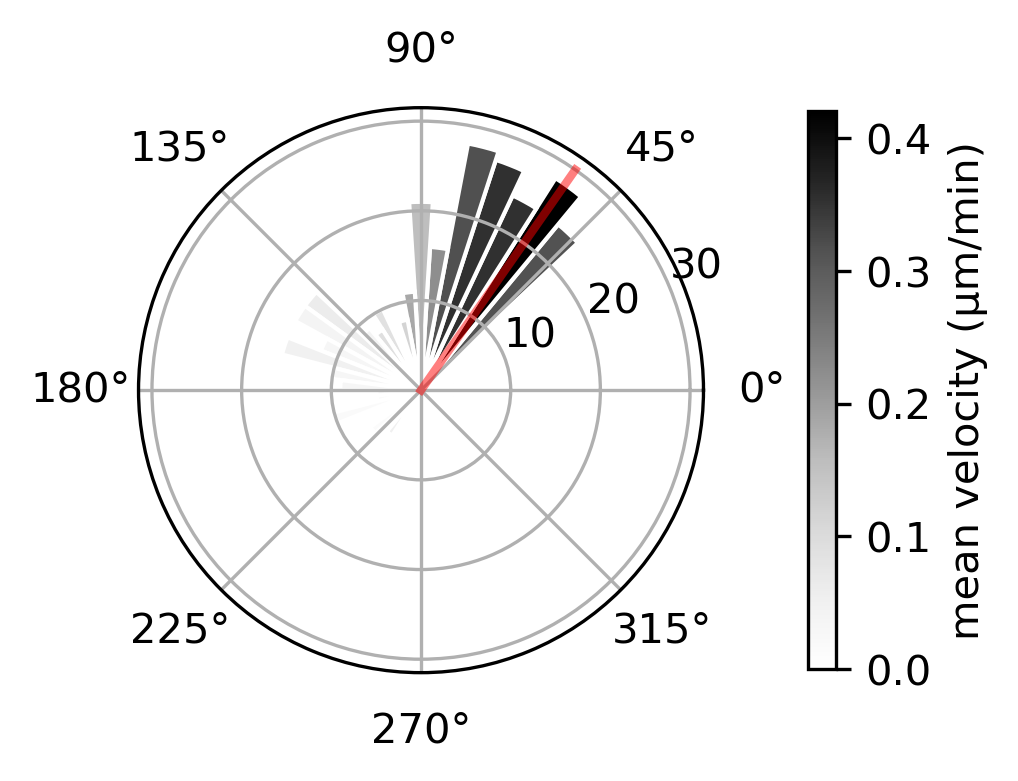

In [12]:
# #Update the figure name!
# rose_plot([1100, 480], 7, 10, 100, 30, 0, np.shape(U)[0], 1.8, 15, "epithelium_mesenchyme_recombination_b1_polar_plot.svg")

In [13]:
# def rose_plot(center, x, y, dist, reference_length, t0, t1):
#     # Having vectors in x and y components. Convert into angles. 
#     # Hitogram counting the number of vectors with corresponding angle. -- for all frames contained in PIV matrix.  
#     # center: [y, x] pixel coordinates for manually defined aggregate center. 
#     # x, y: the rection components of the reference polarisation vector. 
#     # dist: radius of squared surounding region. 
#     # reference_length: For visualisation of reference polarisation vector direction. Manually determine the length. 
    
#     # Calculate the averaged surounding flow vectors for all frames contained in PIV matrix U. 
#     avg_u, avg_v = avrage_neighbour_direction_over_time(center, t0, t1, dist, xgrid, ygrid, U, V)
#     # Calculate angles for each of the averaged flow vector. 
#     angles = np.arctan2(-avg_v, avg_u)
    
#     # Extra refrence polarisation vecotor for highlighting. 
#     extra_angle = np.arctan2(y, x)
    
#     # Plot in a rose plot. Histogramm counting the number of vectors with certain angle. 
#     plt.figure(figsize=(3, 3), dpi=300)
#     ax = plt.subplot(111, projection='polar')
#     num_bins = 50
#     bins = np.linspace(-np.pi, np.pi, num_bins + 1)
#     ax.hist(angles, bins=bins,  color='c', edgecolor='black') # The number of vectors with certain angle.
#     ax.plot([extra_angle, extra_angle], [0, reference_length], color='red', linewidth=2, label='Highlighted Vector', alpha=0.5)
#     plt.show()

In [14]:
def dot_product_polarisation_to_avg_vectors(avg_u, avg_v, polar_u, polar_v):
    # Having multiple average vectors from neighbour regions, calculate the dot product between average vectors and polarization vectors.
    # avg_u, -avg_v: the x and y components of average flow vectors. The values are in order of frame number/time.
    # polar_u, polar_v: the x and y components of reference vector. 

    # Normalization of average flow vectors.
    magnitude_flow_vector = np.sqrt(avg_u**2 + avg_v**2)
    magnitude_flow_vector[magnitude_flow_vector==0] = 1e-10 # Prevent division by zero.
    avg_u_normalized = avg_u / magnitude_flow_vector
    avg_v_normalized = avg_v / magnitude_flow_vector

    # Normalization of reference vector. 
    magnitude_ref_vector = np.sqrt(polar_u**2 + polar_v**2) # Known the reference vector has non-zero magnitude.
    polar_u_normalized = polar_u / magnitude_ref_vector
    polar_v_normalized = polar_v / magnitude_ref_vector

    # Calculation of dot product. Apply term: dot_product = x_ref * x + y_ref * y.
    dot_products = polar_u_normalized * avg_u_normalized + polar_v_normalized * avg_v_normalized

    return dot_products

In [15]:
def angle_velocity_plot(center, x, y, pxl_conversion, time_conversion):
    # center: [y, x] coordinates of the aggregate center. 
    # x: x direction component of the reference vector.
    # y: y direction component of the reference vector. 
    
    t0 = 0
    t1 = np.shape(U)[0]

    # Average flow vector from neighbour region. 
    avg_u, avg_v = avrage_neighbour_direction_over_time(center, t0, t1, 100, xgrid, ygrid, U, V)
    # Dot product between avgerage flow vector and reference vector. (in frame order)
    angle_all_frame = dot_product_polarisation_to_avg_vectors(avg_u, -avg_v, x, y)
    
    fig, ax = plt.subplots(1,1, facecolor=(1, 1, 1), dpi=300, figsize=(4, 2))
    # Plot with two y-axis.
    twin_stacked = ax.twinx()
    time_axis = np.array([i * time_conversion for i in range(len(avg_u))])
    # Plot for dot product.
    p1 = ax.plot(time_axis, angle_all_frame, alpha=0.3, zorder=0)
    # Add median filter for smoothing. 
    p2 = ax.plot(time_axis, median_filter(angle_all_frame, size=30, mode="nearest"), c="blue", zorder=1)
    ax.set_ylabel('dot product')
    # Plot for velocity. 
    velocity = np.sqrt(avg_u**2 + avg_v**2) * pxl_conversion / time_conversion
    twin1 = twin_stacked.scatter(time_axis, velocity, alpha=0.2, c="orange", zorder=2)
    # Apply median filter for smoothing.
    twin2 = twin_stacked.plot(time_axis, median_filter(velocity, size=30, mode="nearest"), c="orange", zorder=3)
    twin_stacked.set_ylabel('velocity (μm/min)')

    # Add line to highlight the maximum velocity (based on median filtered).
    maxi_velocity_frame = np.argmax(median_filter(velocity, size=30, mode="nearest"))
    ax.axvline(x = maxi_velocity_frame * time_conversion, color="red")
    
    ax.set_xlabel("time (min) ")
    plt.savefig("lateral_cut_v2_dot_product_velocity.svg", format="svg")
    plt.show()
    
    return maxi_velocity_frame

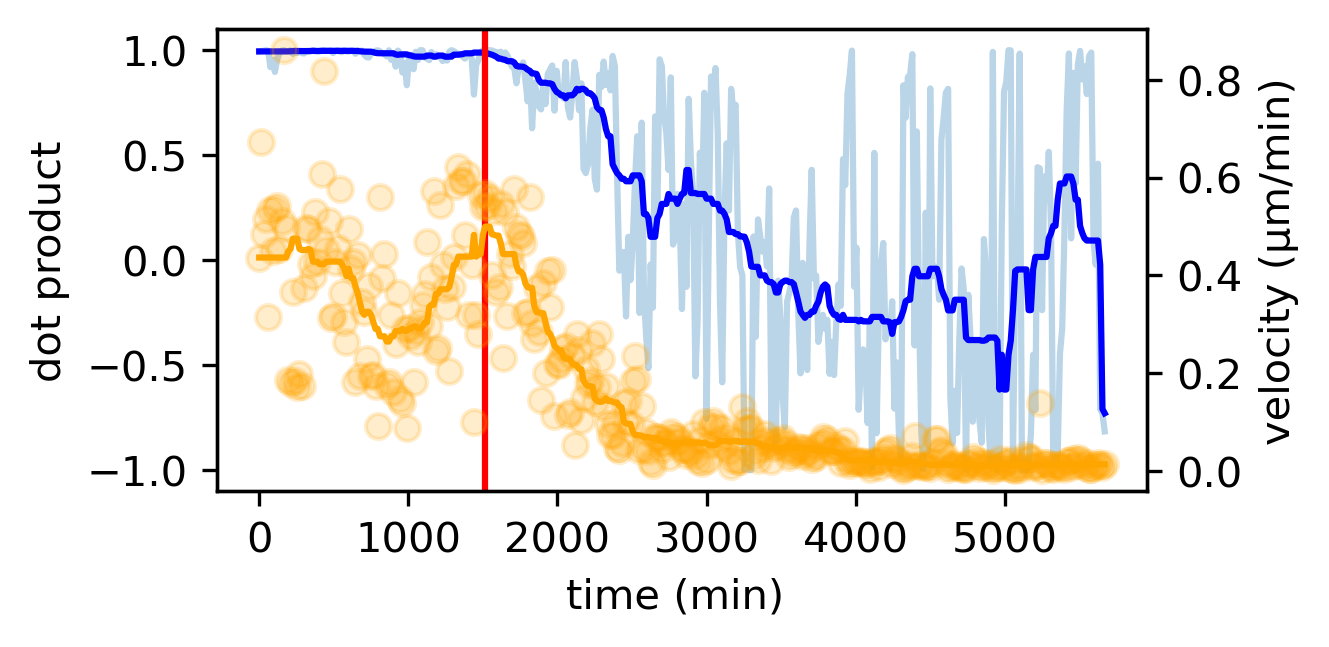

101

In [17]:
# angle_velocity_plot([1100, 480], 7, 10, 1.8, 15)